<a href="https://colab.research.google.com/github/sajal-code/python-random-quote/blob/master/Bert_Sentiment_Classification_for_JIRA_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install transformers

In [4]:
#Import required Libraries 
import torch 
import numpy as np 
import os 
import random 
import pandas as pd 
from tqdm.notebook import tqdm 
from sklearn.model_selection import train_test_split 
from transformers import BertTokenizer 
from torch.utils.data import TensorDataset 
from transformers import BertForSequenceClassification 
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler 
from sklearn.metrics import f1_score 
import matplotlib.pyplot as plt
import seaborn as sns
#Loading data from Google drive 
from google.colab import drive 
drive.mount('/content/drive') 
os.chdir('/content/drive/My Drive/Thesis Dataset/CSV File') # EXAMPLE: /content/drive/My Drive/Sentiment_analysis_using_BERT 
df = pd.read_csv("Jira.csv")
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Comment,Sentiment
0,Committed. Thanks Ning,Positive
1,Sorry I meant ZOOKEEPER-1239.,Negative
2,Hi Ted Matteo Thanks for the review. The co...,Positive
3,Thanks to both of you and to Deepesh for the ...,Positive
4,I just committed this. thanks steven!,Positive


In [5]:
df.Sentiment.value_counts()

Positive    1105
Negative     763
Neutral      701
Name: Sentiment, dtype: int64

In [6]:
possible_labels = df.Sentiment.unique()
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index

In [7]:
df['label'] = df.Sentiment.replace(label_dict)

In [8]:
X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.20, 
                                                  random_state=17, 
                                                  stratify=df.label.values)

In [9]:
df['data_type'] = ['not_set']*df.shape[0]

In [10]:
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

In [11]:
df.groupby(['Sentiment', 'label', 'data_type']).count()

Comment
Sentiment label data_type         
Negative  1     train          610
                val            153
Neutral   2     train          561
                val            140
Positive  0     train          884
                val            221

In [12]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)

In [13]:
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].Comment.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].Comment.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [14]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [15]:
len(dataset_train)

2055

In [16]:
len(dataset_val)

514

In [17]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [18]:
batch_size = 32

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

In [19]:
from transformers import AdamW, get_linear_schedule_with_warmup
optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)

In [20]:
epochs = 10

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [21]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

In [22]:
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [23]:
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


In [25]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [26]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

In [27]:
training_stats = []

for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'finetuned_BERT_epoch_{epoch}.model')
    
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    
    training_stats.append(
        {
            'epoch': epoch,
            'Training Loss': loss_train_avg,
            'Validation Loss': val_loss
        }
    )


Epoch 1
Training loss: 0.8142208310273977
Validation loss: 0.5421952868209166
F1 Score (Weighted): 0.8200464111679134



Epoch 2
Training loss: 0.4118821742442938
Validation loss: 0.34330085884122286
F1 Score (Weighted): 0.8687904889176458



Epoch 3
Training loss: 0.24343846784188197
Validation loss: 0.29263191100429087
F1 Score (Weighted): 0.8931376064018918



Epoch 4
Training loss: 0.1582840061531617
Validation loss: 0.28672872965826707
F1 Score (Weighted): 0.8920816718443108



Epoch 5
Training loss: 0.1091630712724649
Validation loss: 0.28381055264788513
F1 Score (Weighted): 0.902966257963826



Epoch 6
Training loss: 0.07155601107157193
Validation loss: 0.2837047007154016
F1 Score (Weighted): 0.9102431691401811



Epoch 7
Training loss: 0.059739704172198586
Validation loss: 0.30485543926410813
F1 Score (Weighted): 0.9071736788039467



Epoch 8
Training loss: 0.038570145646540016
Validation loss: 0.29424568495767955
F1 Score (Weighted): 0.9108743254314184



Epoch 9
Training loss: 0.03378313671654234
Validation loss: 0.3109158348182545
F1 Score (Weighted): 0.9122780205738492



Epoch 10
Training loss: 0.02916521132708742
Validation loss: 0.32045303816523624
F1 Score (Weighted): 0.9101874973292395



In [28]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Display the table.
df_stats

,epoch,Training Loss,Validation Loss
0,1,0.81,0.54
1,2,0.41,0.34
2,3,0.24,0.29
3,4,0.16,0.29
4,5,0.11,0.28
5,6,0.07,0.28
6,7,0.06,0.30
7,8,0.04,0.29
8,9,0.03,0.31
9,10,0.03,0.32


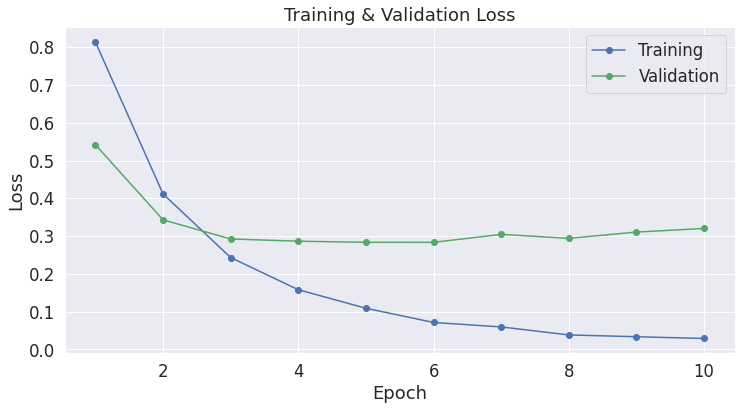

In [31]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['epoch'], df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['epoch'], df_stats['Validation Loss'], 'g-o', label="Validation")
#plt.axis(df_stats['epoch'])

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [32]:
_, predictions, true_vals = evaluate(dataloader_validation)

accuracy_per_class(predictions, true_vals)

Class: Positive
Accuracy: 216/221

Class: Negative
Accuracy: 146/153

Class: Neutral
Accuracy: 107/140

